In [1]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3

In [3]:
# lf.create_sql_db(path="D:/DC3", data_path="D:/waterschap-aa-en-maas_sewage_2019")

conn = sqlite3.connect("D:/DC3/sewer_data.db")
rain_query = "SELECT * FROM rain"
rain_data = pd.read_sql_query(rain_query, conn)

rain_prediction = lf.get_rain_prediction("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_grid_prediction/knmi.harmonie_2018-01-01_2019-08-29",
                                         reduce_grid=True)
data = lf.sdf("D:/waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [84]:
print("%d bytes" % (rain_prediction[1].size * rain_prediction[1].itemsize))

1502686080 bytes


In [9]:
example_grid = np.array(range(300*300)).reshape(300,300)

In [20]:
def cell_index(x, y, reduced=False):    
    x_space = np.linspace(start = -0.0185, stop = -0.0185 + 300*0.037, num = 301)
    y_space = np.linspace(start = 48.9885, stop = 48.9885 + 300*0.023, num = 301)
        
    x_out = np.where(x >= x_space)[0][-1]
    y_out = 300 - np.where(y <= y_space)[0][0]
    
    if reduced:
        x_out = x_out - 101
        y_out = y_out - 91
    
    return x_out, y_out

In [5]:
cell_index(-0.0185, 55.8885)

(0, 0)

In [6]:
cell_index(11.0815, 48.9885)

(300, 300)

In [7]:
cell_index(5.35716, 51.7221)

(145, 181)

In [10]:
example_grid[181, 145]

54445

In [21]:
cell_index(5.35716, 51.7221, reduced=True)

(44, 90)

In [25]:
example_grid[91:(195+1) ,101:(223+1)][90, 44]

54445

In [311]:
haha.area_data.iloc[1]

sewer_system                                          HER-ROS-OVE
area_name                                    gebied E; Overlaet E
area_ID                                                        97
area                                                       711823
geometry        POLYGON ((153801.956 415030.312, 153801.194 41...
x                                                         5.35716
y                                                         51.7221
loc                                                        (8, 5)
Name: 1, dtype: object

In [118]:
rain_prediction[1][1].shape

(27, 23)

In [80]:
def cell_index(x, y, reduced=False):    
    x_space = np.linspace(start = -0.0185, stop = -0.0185 + 300*0.037, num = 301)
    y_space = np.linspace(start = 48.9885, stop = 48.9885 + 300*0.023, num = 301)
        
    x_out = np.where(x >= x_space)[0][-1]
    y_out = 300 - np.where(y <= y_space)[0][0]
    
    if reduced:
        x_out = x_out - 91
        y_out = y_out - 101
    
    return x_out, y_out

vec_cell_index = np.vectorize(cell_index)


class pred_to_rain:
    def __init__(self, rain_data, rain_prediction, area_data):
        reduced = rain_prediction[1].shape[1] < 300
        
        if rain_data["Start"].dtype != "<M8[ns]":
            rain_data["Start"] = pd.to_datetime(rain_data["Start"])
        
        # Sort rain data by time
        rain_data.sort_values("Start", inplace=True)
        rain_data.reset_index(drop=True, inplace=True)
        
        # Narrow area data to streets that occur in rain data
        area_data = area_data.loc[area_data["area_name"].isin(rain_data.columns)].reset_index(drop=True)
        
        # Add column of row/column index in prediction grid
        area_data["x"] = area_data["geometry"].to_crs({'init': 'epsg:4326'}).centroid.x
        area_data["y"] = area_data["geometry"].to_crs({'init': 'epsg:4326'}).centroid.y
        
        # Get grid indices for x and y coordinates
        indices = vec_cell_index(area_data["x"], area_data["y"], reduced=reduced)
        indices = list(zip(indices[0], indices[1]))
        area_data["loc"] = indices
        
        # 
        rain_data_times = rain_data["Start"].apply(lambda i: i.replace(minute=0))
        base_time = rain_data_times[0]
        rain_data_int_times = rain_data_times.apply(lambda i: int((i - base_time).total_seconds()))
        
        date_to_index = pd.Series(range(len(rain_prediction[0])),
                                  index = rain_prediction[0]["start"]\
                                  .apply(lambda i: int((i - base_time).total_seconds())))
        
        # grid_layers: index of rain prediction grid layer for each 'Start'-TimeStamp
        # in rain_data
        grid_layers = date_to_index.loc[date_to_index.index.intersection(rain_data_int_times)]
        grid_layers = grid_layers.loc[~grid_layers.index.duplicated(keep='first')]
        
        # ADD DATA TO CLASS
        self.rain_data = rain_data
        self.rain_prediction = rain_prediction
        self.area_data = area_data
        self.grid_layers = grid_layers
        self.base_time = base_time

    def exact(self):
        rain_values = self.area_data["loc"].apply(lambda i: pd.Series(rain_prediction[1][self.grid_layers, i[1], i[0]]))
        rain_values.index = self.area_data["area_name"]
        rain_values = rain_values.T
        rain_values["Start"] = pd.Series(self.grid_layers.index)\
                                         .apply(lambda i: self.base_time + datetime.timedelta(seconds = i))
        rain_values["End"] = rain_values["Start"].apply(lambda i: i + datetime.timedelta(hours = 1))
        rain_values = rain_values.loc[:,~rain_values.columns.duplicated()]
        
        return rain_values
    
    def estimated(self):
        pass
    
    def score(self, table, measure="correlation"):
        actual = self.rain_data.loc[:,set(self.rain_data.columns.intersection(table.columns))]
        actual = actual.set_index("Start").loc[set(table["Start"])].dropna(axis=0).reset_index(drop=False)
        actual = actual.drop(["Start", "End"], axis=1)
        
        predicted = table.set_index("Start").loc[set(table["Start"]), actual.columns].reset_index(drop=False)
        
        print(actual.shape)
        print(predicted.shape)
        
        actual = actual.stack().reset_index(drop=True)
        predicted = predicted.stack().reset_index(drop=True)
        
        print(actual.shape)
        print(predicted.shape)
        
        if measure == "correlation":
            return actual[predicted >= 0].corr(predicted[predicted >= 0])

In [76]:
x.shape

(13150, 421)

In [81]:
haha = pred_to_rain(rain_data, rain_prediction, data.area_data)

In [82]:
x = haha.exact()

In [83]:
haha.score(x)

(14893, 419)
(13150, 420)
(6240167,)
(5523000,)


TypeError: Cannot compare type 'Timestamp' with type 'int'

In [35]:
x["Start"]

0       2018-01-02 00:00:00
1       2018-01-02 01:00:00
2       2018-01-02 02:00:00
3       2018-01-02 03:00:00
4       2018-01-02 04:00:00
5       2018-01-02 05:00:00
6       2018-01-02 06:00:00
7       2018-01-02 07:00:00
8       2018-01-02 08:00:00
9       2018-01-02 09:00:00
10      2018-01-02 10:00:00
11      2018-01-02 11:00:00
12      2018-01-02 12:00:00
13      2018-01-02 13:00:00
14      2018-01-02 14:00:00
15      2018-01-02 15:00:00
16      2018-01-02 16:00:00
17      2018-01-02 17:00:00
18      2018-01-02 18:00:00
19      2018-01-02 19:00:00
20      2018-01-02 20:00:00
21      2018-01-02 21:00:00
22      2018-01-02 22:00:00
23      2018-01-02 23:00:00
24      2018-01-03 00:00:00
25      2018-01-03 01:00:00
26      2018-01-03 02:00:00
27      2018-01-03 03:00:00
28      2018-01-03 04:00:00
29      2018-01-03 05:00:00
                ...        
13120   2019-08-06 18:00:00
13121   2019-08-06 19:00:00
13122   2019-08-06 20:00:00
13123   2019-08-06 21:00:00
13124   2019-08-06 2

In [42]:
haha.rain_data["Start"].apply(lambda i: i in x["Start"])

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
128072    False
128073    False
128074    False
128075    False
128076    False
128077    False
128078    False
128079    False
128080    False
128081    False
128082    False
128083    False
128084    False
128085    False
128086    False
128087    False
128088    False
128089    False
128090    False
128091    False
128092    False
128093    False
128094    False
128095    False
128096    False
128097    False
128098    False
128099    False
128100    False
128101    False
Name: Start, Length: 128

In [355]:
print(min(haha.area_data["x"]))
max(haha.area_data["x"])

5.120952422027676


6.03589154146531

In [356]:
print(min(haha.area_data["y"]))
max(haha.area_data["y"])

51.3484495682325


51.82362837985545

In [68]:
lol = haha.rain_data.loc[:,set(haha.rain_data.columns.intersection(x.columns))]

In [78]:
haha.rain_data.drop(["Start", "End", "Kwaliteit"], axis=1).stack().reset_index(drop=True)

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
           ... 
55218728    0.0
55218729    0.0
55218730    0.0
55218731    0.0
55218732    0.0
55218733    0.0
55218734    0.0
55218735    0.0
55218736    0.0
55218737    0.0
55218738    0.0
55218739    0.0
55218740    0.0
55218741    0.0
55218742    0.0
55218743    0.0
55218744    0.0
55218745    0.0
55218746    0.0
55218747    0.0
55218748    0.0
55218749    0.0
55218750    0.0
55218751    0.0
55218752    0.0
55218753    0.0
55218754    0.0
55218755    0.0
55218756    0.0
55218757    0.0
Length: 55218758, dtype:

In [37]:
len(set(x.columns.intersection(haha.rain_data.columns)))

421

In [184]:
x # prior

area_name,30. Akkers I,gebied E; Overlaet E,Geb. 8 Orthenpoort,de Brand,Westerbroek,gebied C1; Hondberg-noord,geb. 6c Carolushof,Gassel,gebied 27; Empel-noord,Maasbroeksche Blokken,...,13. Groenveld,Binnenveld,Milheeze,08. Stiphout,Langenboom,Deursen,Dennenburg,RG Slievenpark,Start,End
0,0.040039,0.017578,0.046875,0.007812,0.014648,0.017578,0.046875,0.103516,0.065430,0.035156,...,0.100586,0.115234,0.115234,0.058594,0.117188,0.032227,0.032227,0.770508,2018-01-02 00:00:00,2018-01-02 01:00:00
1,0.399414,0.688477,0.777344,0.735352,0.807617,0.688477,0.777344,0.471680,0.671875,0.109375,...,0.310547,0.264648,0.264648,0.398438,0.606445,0.359375,0.359375,0.307617,2018-01-02 01:00:00,2018-01-02 02:00:00
2,0.652344,2.736328,1.545898,2.231445,1.741211,2.736328,1.545898,0.591797,2.518555,1.000000,...,0.389648,0.387695,0.387695,0.618164,1.199219,0.110352,0.110352,0.385742,2018-01-02 02:00:00,2018-01-02 03:00:00
3,1.079476,3.830453,2.790414,4.244515,3.539437,3.830453,2.790414,0.104867,3.018929,0.975961,...,1.589242,1.834360,1.834360,1.179086,0.379281,0.002328,0.002328,1.056039,2018-01-02 03:00:00,2018-01-02 04:00:00
4,0.327420,3.644804,2.135038,3.396757,3.122343,3.644804,2.135038,-0.000705,2.846952,0.004178,...,1.013944,1.535428,1.535428,0.337186,0.002225,-0.000705,-0.000705,0.383084,2018-01-02 04:00:00,2018-01-02 05:00:00
5,0.553711,2.171875,0.683594,1.618164,1.675781,2.171875,0.683594,0.083008,2.092773,0.107422,...,1.740234,2.187500,2.187500,0.377930,0.162109,0.036133,0.036133,0.822266,2018-01-02 05:00:00,2018-01-02 06:00:00
6,0.383789,0.016602,0.006836,0.021484,0.079102,0.016602,0.006836,0.000977,0.004883,0.026367,...,1.515625,2.156250,2.156250,0.413086,0.021484,0.000000,0.000000,0.383789,2018-01-02 06:00:00,2018-01-02 07:00:00
7,0.274414,0.002930,0.008789,0.001953,0.003906,0.002930,0.008789,0.190430,0.000977,0.180664,...,0.062500,0.033203,0.033203,0.326172,0.233398,0.071289,0.071289,0.051758,2018-01-02 07:00:00,2018-01-02 08:00:00
8,0.110352,0.000977,0.000977,0.000977,0.001953,0.000977,0.000977,0.065430,0.000977,0.129883,...,0.041016,0.044922,0.044922,0.097656,0.156250,0.007812,0.007812,0.114258,2018-01-02 08:00:00,2018-01-02 09:00:00
9,0.073242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059570,0.000000,0.193359,...,0.006836,0.007812,0.007812,0.051758,0.082031,0.033203,0.033203,0.072266,2018-01-02 09:00:00,2018-01-02 10:00:00


In [49]:
print(min(data.RWZI_regions.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[0])))
print(min(data.RWZI_regions.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[1])))
print(max(data.RWZI_regions.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[2])))
print(max(data.RWZI_regions.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[3])))

5.068951374571076
51.321073315897294
6.048120780085531
51.83075095586633


In [50]:
print(min(data.area_data.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[0])))
print(min(data.area_data.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[1])))
print(max(data.area_data.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[2])))
print(max(data.area_data.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[3])))

5.085878387155967
51.34635488081531
6.037654893800312
51.82793769130808


In [362]:
# 53.555 NORTHMOST
# 50.750417 SOUTHMOST
# 3.358333 WestMOST
# 7.227778 EASTMOST
cell_index(3.358333, 53.555)

(91, 101)

In [363]:
cell_index(7.227778, 50.750417)

(195, 223)

In [46]:
data.RWZI_regions

,RWZI_name,geometry
0,R.W.Z.I. Asten,"POLYGON ((179944.9 386061.09, 179838.507 38574..."
1,R.W.Z.I. Aarle-Rixtel,"POLYGON ((182680.943 401081.192, 182705.138 40..."
2,R.W.Z.I. Dinther,"POLYGON ((170102.43 412464.901, 170105.662 412..."
3,R.W.Z.I. Oijen,"(POLYGON ((165400 425304, 165500 425300, 16560..."
4,R.W.Z.I. Den Bosch,"POLYGON ((144351.894 416881.192, 144400 416848..."
5,R.W.Z.I. Vinkel,"(POLYGON ((165263.935 417543.753, 165251.942 4..."
6,R.W.Z.I. Land van Cuijk,"POLYGON ((188802.669 418268.455, 188861.128 41..."


In [47]:
data.RWZI_regions.to_crs({'init': 'epsg:4326'})["geometry"].apply(lambda i: i.bounds[0])

0    5.626748
1    5.534345
2    5.371123
3    5.304406
4    5.068951
5    5.341328
6    5.618366
Name: geometry, dtype: float64

In [41]:
y.bounds

(5.62674775444747, 51.321073315897294, 5.931287597326973, 51.4654517168163)

In [43]:
min(y

0    5.626748
1    5.534345
2    5.371123
3    5.304406
4    5.068951
5    5.341328
6    5.618366
Name: geometry, dtype: float64

In [114]:
rain_data["Start"] = pd.to_datetime(rain_data["Start"])

In [160]:
rd = rain_data.iloc[:,3:]

In [161]:
rd = rd.groupby(rain_data["Start"].apply(lambda i: i.date())).sum()

In [162]:
y = x.groupby(x["Start"].apply(lambda i: i.date())).sum()

In [163]:
lekerstraat_actual = rd.loc[pd.Series(y.index), "Rips"]

In [164]:
lekerstraat_predicted = y["Rips"]#.iloc[:,0]

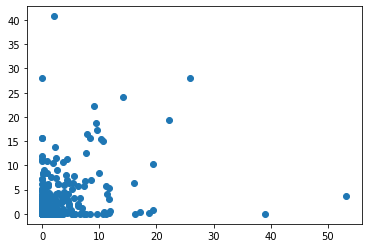

In [167]:
plt.scatter(x = lekerstraat_actual[lekerstraat_predicted>=0],
            y= lekerstraat_predicted[lekerstraat_predicted>=0])

In [168]:
np.corrcoef(lekerstraat_actual[lekerstraat_predicted>=0], lekerstraat_predicted[lekerstraat_predicted>=0])

array([[1.        , 0.33330716],
       [0.33330716, 1.        ]])

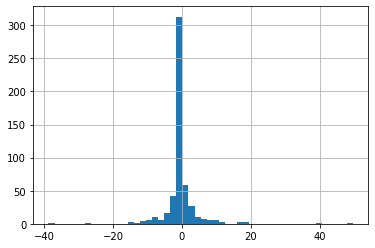

In [170]:
(lekerstraat_actual[lekerstraat_predicted>=0]-lekerstraat_predicted[lekerstraat_predicted>=0]).hist(bins=50)

In [96]:
min(lekerstraat_predicted) # LEKERSTRAAT MAY NOT BE CORRECT

-9999.0

In [99]:
rain_data

,Start,End,Kwaliteit,Lekerstraat,11. Speelweide/Vlinkert,Rips,Handel,14. Koolhof,13. Heiakker,Vlierden,...,Ooivaarsrijt,de Brand,Bitswijk,de Geer-zuid,De Hoeven(Haarsteeg),11+19 Grevekeur,CHV-terrein,Geb. 12 Vughterpoort,Heusdenseweg(Haarsteeg),Bosscheweg
0,2017-12-31 23:00:00,01-01-2018 00:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2018-01-01 00:00:00,01-01-2018 01:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0124,0.0000,0.0000,0.0000,0.0000,0.0000
2,2018-01-01 01:00:00,01-01-2018 02:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0244,0.0082,0.0000,0.0789,0.0489,0.0000,0.0000,0.0820,0.0000
3,2018-01-01 02:00:00,01-01-2018 03:00:00,HydroNET D2,0.0000,0.0223,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0186,0.0932,0.0199,0.0689,0.0186,0.0373,0.0351,0.0609,0.0205,0.0000
4,2018-01-01 03:00:00,01-01-2018 04:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0477,0.0049,0.0032,...,0.1992,0.0509,0.0264,0.0984,0.0036,0.0269,0.0110,0.0323,0.0176,0.0000
5,2018-01-01 04:00:00,01-01-2018 05:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0197,0.1833,0.0000,0.0231,0.0672,0.0000,0.0000,0.0000
6,2018-01-01 05:00:00,01-01-2018 06:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.2495,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,2018-01-01 06:00:00,01-01-2018 07:00:00,HydroNET D2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,2018-01-01 07:00:00,01-01-2018 08:00:00,HydroNET D2,0.2993,0.0875,0.0000,0.1210,0.0000,0.0000,0.0818,...,0.0186,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,2018-01-01 08:00:00,01-01-2018 09:00:00,HydroNET D2,0.1071,0.0631,0.1508,0.5420,0.1091,0.0925,0.0729,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [100]:
x["Rips"]

0        0.081055
1        1.116211
2        0.048829
3        0.087289
4        0.052030
5        0.005859
6        0.000000
7        0.008789
8        0.004883
9        0.046875
10       0.008789
11       0.064453
12       0.012695
13       0.000673
14       0.000151
15       0.001813
16       0.002341
17       0.013701
18       0.156717
19       0.189914
20       0.722157
21       0.569129
22       0.599609
23       0.086914
24       1.217299
25       0.219239
26       1.140625
27       1.970020
28       4.292529
29       1.918822
           ...   
13120    0.000000
13121    0.000000
13122    0.000000
13123    0.000000
13124    0.000000
13125    0.000000
13126    0.001953
13127    0.007812
13128    0.722656
13129    0.027344
13130    0.000000
13131    0.000000
13132    0.000000
13133    0.000000
13134    0.000000
13135    0.000000
13136    0.000000
13137    0.027344
13138    1.023438
13139    0.199219
13140    1.812500
13141    0.021484
13142    0.001953
13143    0.000000
13144    0